# Replicate Vanderburg & Johnson 2014 K2SFF Method

In this notebook we will replicate the K2SFF method from [Vanderburg and Johnson 2014](http://adsabs.harvard.edu/abs/2014PASP..126..948V).  The paper introduces a method for "Self Flat Fielding", by tracking how the lightcurve changes with motion of the spacecraft.

In [44]:
from pyke import KeplerTargetPixelFile
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt

In [45]:
#from oktopus import UniformPrior, JointPrior
#from pyke import PRFPhotometry, SceneModel
#from pyke.utils import KeplerQualityFlags

## Get data

In [46]:
#! wget https://www.cfa.harvard.edu/~avanderb/k2/ep60021426alldiagnostics.csv

In [47]:
import pandas as pd

In [48]:
df = pd.read_csv('ep60021426alldiagnostics.csv',index_col=False)

In [49]:
df.head()

,BJD - 2454833,Raw Flux,Corrected Flux,X-centroid,Y-centroid,arclength,Correction,Thrusters On
0,1862.502368,0.995119,0.995985,25.135097,24.661074,2.327480,0.999130,1.0
1,1862.522801,0.997313,0.996767,25.289752,24.418689,1.175322,1.000548,1.0
2,1862.543235,0.996713,0.996136,25.288052,24.429406,1.214627,1.000580,0.0
3,1862.563668,0.996930,0.996277,25.275216,24.448405,1.306617,1.000656,0.0
4,1862.584102,0.996862,0.996228,25.253864,24.480184,1.460259,1.000636,0.0


Let's use the provided $x-y$ centroids, but we could compute these on our own too.

In [50]:
col = df[' X-centroid'].values
col = col - np.mean(col)
row = df[' Y-centroid'].values 
row = row - np.mean(row)

In [51]:
def _get_eigen_vectors(centroid_col, centroid_row):
    centroids = np.array([centroid_col, centroid_row])
    eig_val, eig_vec = np.linalg.eigh(np.cov(centroids))
    return eig_val, eig_vec

In [52]:
def _rotate(eig_vec, centroid_col, centroid_row):
    centroids = np.array([centroid_col, centroid_row])
    return np.dot(eig_vec, centroids)

In [53]:
eig_val, eig_vec = _get_eigen_vectors(col, row)

In [54]:
v1, v2 = eig_vec

The major axis is the last one.

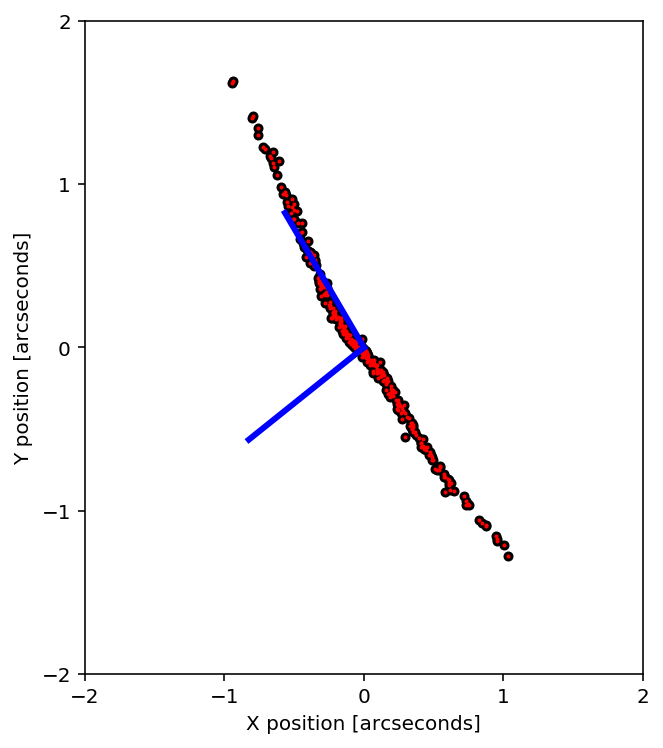

In [55]:
plt.figure(figsize=(5, 6))
plt.plot(col*4.0, row*4.0, 'ko', ms=4)
plt.plot(col*4.0, row*4.0, 'ro', ms=1)
plt.xticks([-2, -1,0, 1, 2])
plt.yticks([-2, -1,0, 1, 2])
plt.xlabel('X position [arcseconds]')
plt.ylabel('Y position [arcseconds]')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.plot([0, v1[0]], [0, v1[1]], color='blue', lw=3)
plt.plot([0, v2[0]], [0, v2[1]], color='blue', lw=3);

Following the form of Figure 2 of Vanderburg & Johsnon 2014.

In [56]:
rot_colp, rot_rowp = _rotate(eig_vec, col, row)

You can rotate into the new reference frame.

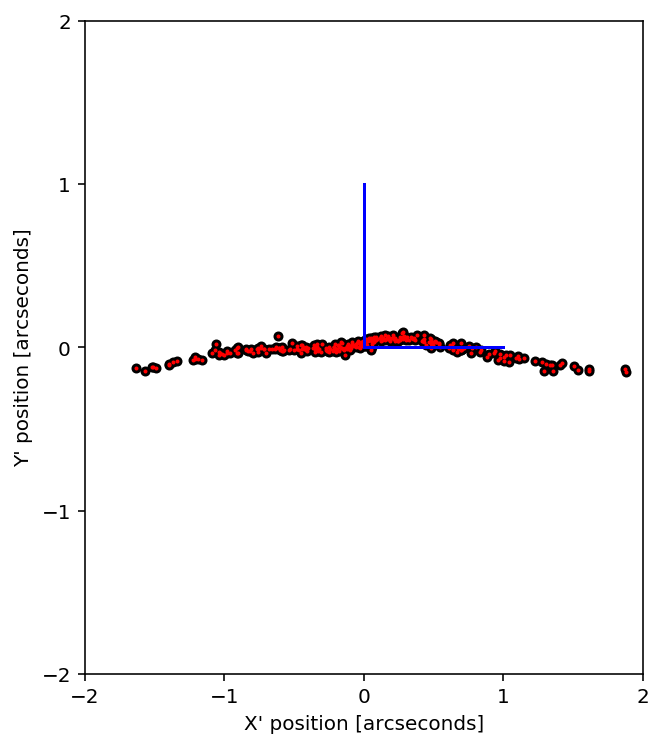

In [57]:
plt.figure(figsize=(5, 6))
plt.plot(rot_rowp*4.0, rot_colp*4.0, 'ko', ms=4)
plt.plot(rot_rowp*4.0, rot_colp*4.0, 'ro', ms=1)
plt.xticks([-2, -1,0, 1, 2])
plt.yticks([-2, -1,0, 1, 2])
plt.xlabel("X' position [arcseconds]")
plt.ylabel("Y' position [arcseconds]")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.plot([0, 1], [0, 0], color='blue')
plt.plot([0, 0], [0, 1], color='blue');

We need to calculate the arclength using:
$$s= \int_{x'_0}^{x'_1}\sqrt{1+\left( \frac{dy'_p}{dx'}\right)^2} dx'$$

> where $x^\prime_0$ is the transformed $x$ coordinate of the point with the smallest $x^\prime$ position, and $y^\prime_p$ is the best--fit polynomial function.

In [58]:
z = np.polyfit(rot_rowp, rot_colp, 5)
p5 = np.poly1d(z)
p5_deriv = p5.deriv()

In [59]:
x0_prime = np.min(rot_rowp)
xmax_prime = np.max(rot_rowp)

In [60]:
x_dense = np.linspace(x0_prime, xmax_prime, 2000)

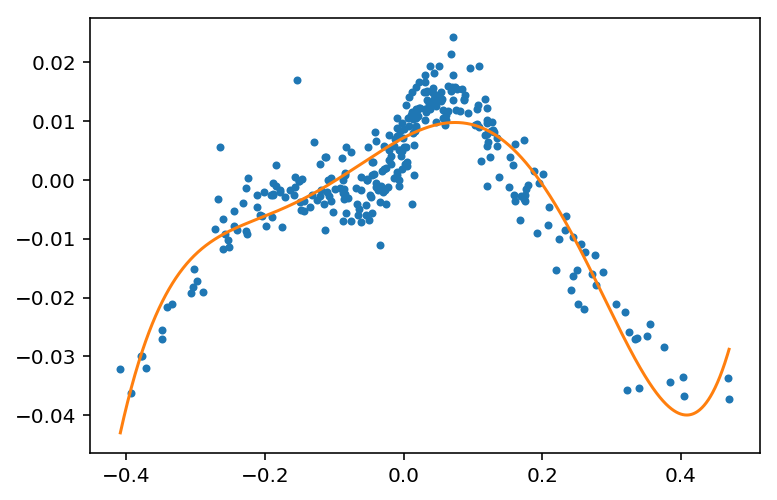

In [61]:
plt.plot(rot_rowp, rot_colp, '.')
plt.plot(x_dense, p5(x_dense));

In [62]:
@np.vectorize
def arclength(x):
    '''Input x1_prime, get out arclength'''
    gi = x_dense <x
    s_integrand = np.sqrt(1 + p5_deriv(x_dense[gi]) ** 2)
    s = np.trapz(s_integrand, x=x_dense[gi])
    return s

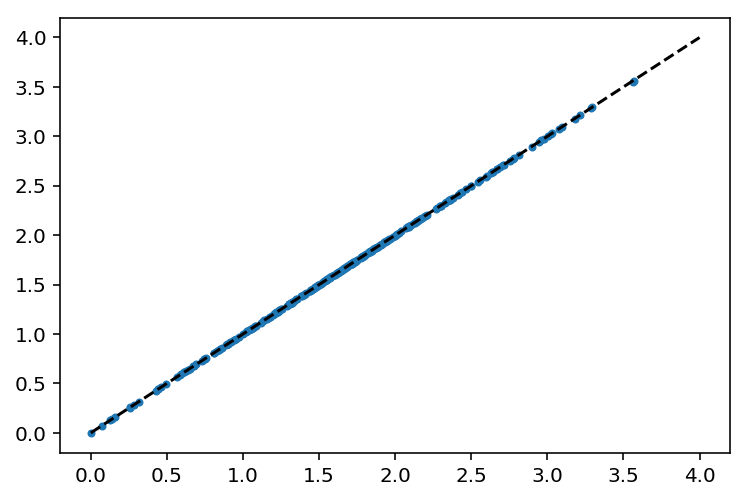

In [63]:
plt.plot(df[' arclength'], arclength(rot_rowp)*4.0, '.')
plt.plot([0, 4], [0, 4], 'k--');

It works!

Now we apply a high-pass filter.  We follow the original paper by using BSplines with 1.5 day breakpoints.

In [64]:
from scipy.interpolate import BSpline
from scipy import interpolate

In [65]:
tt, ff = df['BJD - 2454833'].values, df[' Raw Flux'].values
tt = tt - tt[0]

In [66]:
knots = np.arange(0, tt[-1], 1.5)

In [67]:
t,c,k = interpolate.splrep(tt, ff, s=0, task=-1, t=knots[1:])

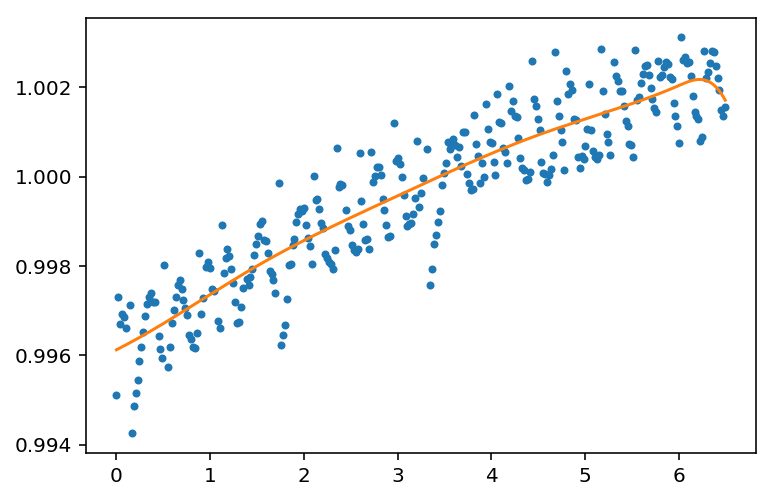

In [68]:
bspl = BSpline(t,c,k)

plt.plot(tt, ff, '.')
plt.plot(tt, bspl(tt))

Spline fit looks good, so normalize the flux by the long-term trend.  
Plot the normalized flux versus arclength to see the position-dependent flux.

In [69]:
norm_ff = ff/bspl(tt)

In [70]:
norm_ff

array([ 0.99898936,  1.00117045,  1.0005462 ,  1.00074139,  1.00065059,
        1.00037015,  1.00085961,  0.99795348,  0.99853609,  0.99879124,
        0.9990766 ,  0.99946248,  0.99975999,  1.00008423,  1.00041058,
        1.00064382,  1.00078908,  1.00086068,  1.00061456,  1.00058779,
        0.99978561,  0.99946187,  0.99923522,  1.00129946,  0.99896307,
        0.99938808,  0.99989193,  1.00016116,  1.00042711,  1.00067319,
        1.00075304,  1.00052638,  1.00025114,  1.00003483,  0.99986812,
        0.99939591,  0.99926522,  0.99905489,  0.99901527,  0.99932231,
        1.00109631,  0.99970508,  1.00002839,  1.00066204,  1.00074416,
        1.00059126,  1.00008728,  1.00003267,  0.99929064,  0.99910546,
        1.00140078,  1.00028795,  1.00059858,  1.00078696,  1.00058918,
        1.00028797,  0.99994398,  0.99948528,  0.99899203,  0.99897276,
        0.99928728,  0.99968773,  0.99985013,  0.99967969,  0.99984175,
        0.99998969,  1.00027779,  1.00050052,  1.00064828,  1.00

Mask the data by keeping only the good samples.

In [79]:
bi = df[' Thrusters On'].values == 1.0
gi = df[' Thrusters On'].values == 0.0
al, gff = arclength(rot_rowp)*4.0, norm_ff

In [80]:
sorted_inds = np.argsort(al)

We will follow the paper by interpolating 15 bins of means.  This is a piecewise linear fit.

In [81]:
knots = np.array([np.min(al)]+ 
                 [np.median(splt) for splt in np.array_split(al[sorted_inds], 15)]+
                 [np.max(al)])

In [82]:
bin_means = np.array([gff[sorted_inds][0]]+
                     [np.mean(splt) for splt in np.array_split(gff[sorted_inds], 15)]+
                     [gff[sorted_inds][-1]])

In [83]:
zz = np.polyfit(al, gff,6)
sff = np.poly1d(zz)
al_dense = np.linspace(0, 4, 1000)
interp_func = interpolate.interp1d(knots, bin_means)

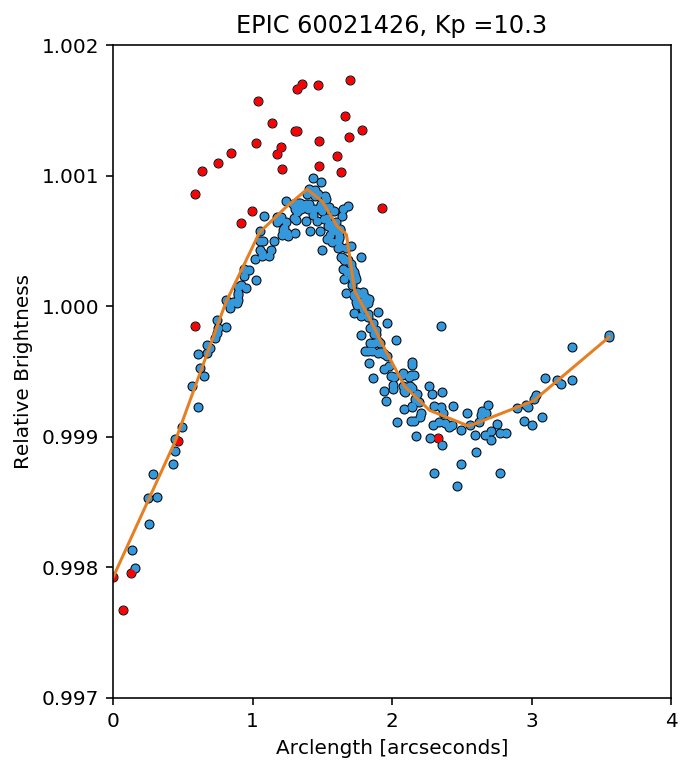

In [84]:
plt.figure(figsize=(5, 6))
plt.plot(arclength(rot_rowp)*4.0, norm_ff, 'ko', ms=4)
plt.plot(arclength(rot_rowp)*4.0, norm_ff, 'o', color='#3498db', ms=3)
plt.plot(arclength(rot_rowp[bi])*4.0, norm_ff[bi], 'o', color='r', ms=3)
#plt.plot(al_dense, sff(al_dense), '-', color='#e67e22')
#plt.plot(knots, bin_means, '-', color='#e67e22')
plt.plot(np.sort(al), interp_func(np.sort(al)), '-', color='#e67e22')

plt.xticks([0, 1,2, 3, 4])
plt.xlabel('Arclength [arcseconds]')
plt.ylabel('Relative Brightness')
plt.title('EPIC 60021426, Kp =10.3')
plt.xlim(0,4)
plt.ylim(0.997, 1.002);

Following Figure 4 of Vanderburg & Johnson 2014.

Apply the Self Flat Field (SFF) correction:

In [85]:
corr_flux = gff / interp_func(al)

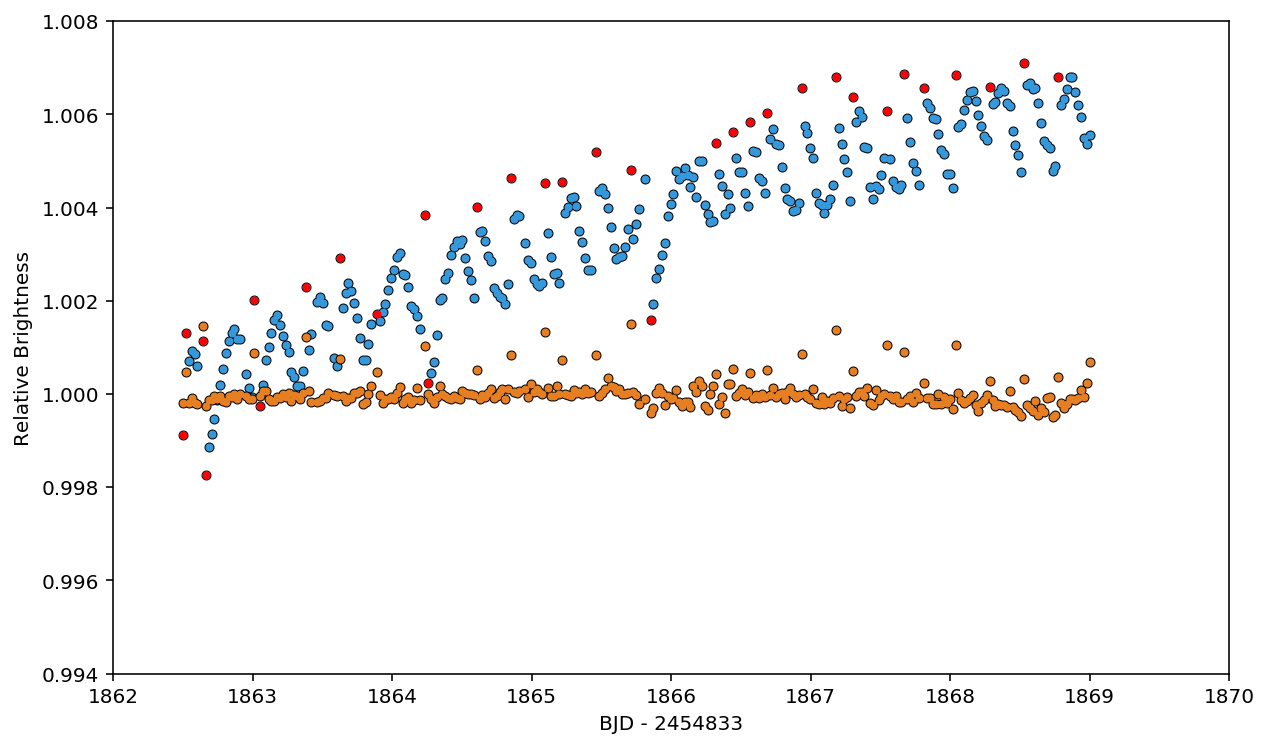

In [86]:
plt.figure(figsize=(10,6))

dy = 0.004
plt.plot(df['BJD - 2454833'], df[' Raw Flux']+dy, 'ko', ms=4)
plt.plot(df['BJD - 2454833'], df[' Raw Flux']+dy, 'o', color='#3498db', ms=3)
plt.plot(df['BJD - 2454833'][bi], df[' Raw Flux'][bi]+dy, 'o', color='r', ms=3)



plt.plot(df['BJD - 2454833'], corr_flux, 'o', color='k', ms = 4)
plt.plot(df['BJD - 2454833'], corr_flux, 'o', color='#e67e22', ms = 3)

#plt.plot(df['BJD - 2454833'][gi], df[' Corrected Flux'][gi], 'o', color='#00ff00', ms = 4)

plt.xlabel('BJD - 2454833')
plt.ylabel('Relative Brightness')

plt.xlim(1862, 1870)
plt.ylim(0.994, 1.008);

In [87]:
corr_flux - np.array([ 0.99981168,  1.00047676,  0.99981414,  0.99992278,  0.99982129,
        0.99979103,  1.00146758,  0.99973237,  0.99987664,  0.99986326,
        0.99995969,  0.99989594,  0.99995878,  0.99985195,  0.99982321,
        0.9999505 ,  0.99994121,  1.00001442,  0.99988973,  0.99998562,
        0.99995115,  0.9998847 ,  0.99989923,  1.00087007,  0.99993833,
        1.00006672,  1.00006013,  0.99988912,  0.99985384,  0.99986113,
        0.9999371 ,  0.9999166 ,  1.00001118,  0.99993987,  1.00001056,
        0.9998399 ,  0.9999871 ,  0.9999499 ,  0.99988729,  1.00003278,
        1.00123407,  1.00006717,  0.99982791,  0.99983701,  0.99985433,
        0.99991549,  0.99992835,  1.00001145,  0.99997999,  0.99994945,
        1.00074576,  0.99996819,  0.99985237,  0.99990718,  0.99990797,
        1.000021  ,  1.00001709,  1.00007062,  0.9997913 ,  0.99982527,
        1.00000749,  1.00016349,  1.00047793,  0.99999072,  0.99981612,
        0.99989252,  0.9998865 ,  0.99993426,  0.99989144,  1.0000151 ,
        1.00015601,  0.9998179 ,  0.99989025,  0.99994646,  0.99981344,
        0.99987707,  1.00013513,  0.9998755 ,  1.00102872,  1.        ,
        0.99988055,  0.99980342,  0.99992568,  1.00017955,  1.00001128,
        0.99996046,  0.99991927,  0.99990209,  0.99994929,  0.99992351,
        0.99989806,  1.00007202,  1.00000625,  1.0000075 ,  1.00000272,
        0.99998321,  1.00050736,  0.99989132,  0.99998575,  0.99992858,
        1.0000457 ,  1.00010077,  0.99991705,  0.99995825,  1.00004552,
        1.0000998 ,  0.99989507,  1.00010462,  1.00084071,  1.0000493 ,
        1.00004102,  1.00006633,  1.00010788,  0.99993379,  1.00021695,
        1.00003739,  1.0001092 ,  1.00005226,  0.99999218,  1.00133272,
        1.00012716,  0.99996103,  0.99996005,  1.00017715,  1.00000095,
        1.00073447,  1.00000981,  0.99998706,  0.99996401,  1.00008901,
        1.00001162,  1.00004853,  1.00000182,  1.00010407,  1.00001789,
        1.00005245,  1.00083591,  0.99995902,  1.00002201,  1.00010257,
        1.00035038,  1.00017642,  1.00014914,  1.00005752,  1.00010381,
        0.99999191,  1.00000937,  1.00001927,  1.00150932,  1.00003345,
        0.9999801 ,  0.99978757,  0.99988233,  0.99958704,  0.99970234,
        1.00001781,  1.00012549,  1.00003217,  0.99977364,  0.99995991,
        0.99989565,  0.99991021,  1.00008892,  0.99983062,  0.99974309,
        0.99984404,  0.99983437,  0.99972699,  1.00016504,  1.00003239,
        1.00025884,  1.00016888,  0.99975134,  0.99965332,  1.00000716,
        1.00017986,  1.00043108,  0.99978731,  0.99994305,  0.9996005 ,
        1.00022556,  1.00021625,  1.00052872,  0.99994128,  1.00003022,
        1.00011835,  0.99996683,  1.00004192,  1.0004533 ,  0.99991287,
        0.99997944,  0.99992404,  0.99998921,  0.99993229,  1.00052528,
        0.99997896,  1.00012765,  0.99993704,  0.99999665,  1.00002763,
        0.99989721,  1.00004338,  1.00013425,  1.00000708,  0.99993303,
        0.99997385,  1.00087593,  1.00000022,  0.99994362,  0.99987408,
        1.00011117,  0.99980117,  0.99977872,  0.99993386,  0.99977829,
        0.99985432,  0.99981768,  0.99990981,  1.0013576 ,  0.99996067,
        0.99973075,  0.9998995 ,  0.9999471 ,  0.99970795,  1.00049818,
        0.99996372,  1.00005018,  1.00004882,  0.99996192,  1.00012518,
        0.99981639,  0.99977239,  1.00007928,  0.99987695,  0.99995035,
        1.        ,  1.00104683,  0.99996478,  0.99989267,  0.99995373,
        0.9998364 ,  0.99982164,  1.00090109,  0.99988488,  0.99996777,
        0.99983494,  1.0000262 ,  0.99991089,  1.00025581,  0.99993431,
        0.99991188,  0.99978365,  0.9997884 ,  0.99999862,  0.99978655,
        0.99993801,  0.99980504,  0.99989824,  0.99968209,  1.00106364,
        1.00002076,  0.99987004,  0.99979943,  0.99984684,  0.99992176,
        0.99999382,  0.99977396,  0.99963716,  0.99979047,  0.99987956,
        0.99998112,  1.00027442,  0.99986102,  0.99975119,  0.99979172,
        0.99976304,  0.99976771,  0.99970689,  1.00007995,  0.99971967,
        0.99965769,  0.99962219,  0.99952935,  1.00032237,  0.99976814,
        0.99969785,  0.9996437 ,  0.99983154,  0.9995444 ,  0.99968972,
        0.9996132 ,  0.99991091,  0.99993539,  0.99950198,  0.99954976,
        1.00035651,  0.99981468,  0.99969077,  0.99978148,  0.99989054,
        0.99989924,  0.99985514,  0.99991165,  1.00008705,  0.99994626,
        1.00023762,  1.00068104])

array([  6.11444766e-07,   1.19784764e-06,  -1.33038752e-06,
        -8.91941959e-07,  -9.27462121e-06,   3.48882025e-06,
         9.54620889e-07,   2.41264260e-06,   5.93126379e-06,
         8.08966853e-06,   3.60892448e-06,   4.43168012e-06,
         2.17217190e-06,   2.99357453e-06,   1.40022513e-06,
        -6.03390210e-07,  -5.57599722e-07,  -5.84897418e-06,
        -3.74939904e-06,   9.59950572e-06,   1.06730169e-06,
         7.37845922e-07,   1.15410107e-06,   3.24001336e-06,
         9.67817511e-06,   6.80208612e-06,  -3.28004970e-06,
         3.57039238e-06,   3.46034271e-06,  -9.65523735e-07,
        -9.35853719e-06,   8.84109479e-06,  -3.24243654e-06,
        -2.06510236e-06,   1.26855011e-06,   8.46576976e-07,
         1.44001596e-06,   9.22756786e-07,  -8.37799040e-07,
        -7.23443282e-07,  -3.58231762e-06,  -1.41247247e-06,
        -1.38484383e-06,  -8.17893807e-07,  -7.75922537e-07,
        -2.27182789e-07,  -6.01783208e-06,   3.05761815e-06,
         1.27995778e-06,

Following Figure 5 of Vanderburg & Johnson 2015.

Let's compute the CDPP:

In [35]:
from pyke import LightCurve

In [36]:
#lc = LightCurve(time=df['BJD - 2454833'][gi], flux=corr_flux*bspl(tt[gi]))
lc = LightCurve(time=df['BJD - 2454833'][gi], flux=df[' Corrected Flux'][gi])

In [37]:
lc.cdpp(savgol_window=201)*1.4

38.872509891106382

The end.